In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchmetrics.functional as evafunc
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
import segmentation_models_pytorch as smp
import os
import imp
import CTimageLIB
imp.reload(CTimageLIB)
from PIL import Image

c:\Users\manjw\.conda\envs\dataEngineering\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\Users\manjw\.conda\envs\dataEngineering\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\manjw\AppData\Local\Temp\ipykernel_5160\3418379195.py:16: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [3]:
# 自定义数据集类
class SpineWeb15(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        file_list = os.listdir(self.data_path)  # 列出文件夹中的所有文件和文件夹
        file_count = len(file_list)  # 获取文件数量
        return file_count
    
    def __getitem__(self, index):
        metadata = np.load(self.data_path+str(index)+".npy")
        image = metadata[0]
        label = metadata[1]

        image_data = torch.from_numpy(image).float()
        label_data = torch.from_numpy(label).float()
        
        if self.transform:
            image_data = self.transform(image_data)
            label_data = self.transform(label_data)
        return image_data, label_data


In [17]:
def calculate_pixel_accuracy(prediction, target):
    # 将预测结果和目标标签进行逐像素比较，并计算正确预测像素的比例
    correct_pixels = (prediction == target).sum()
    total_pixels = target.size
    return correct_pixels, total_pixels

def calculate_iou(pred, target):
    intersection = np.logical_and(pred, target)
    union = np.logical_or(pred, target)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice(pred, target):
    intersection = np.logical_and(pred, target)
    dice_score = 2 * np.sum(intersection) / (np.sum(pred) + np.sum(target))
    return dice_score

def visualize_results(image,label,output):
    fig, axes = plt.subplots(3, 1)
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('image')
    axes[1].imshow(label, cmap='gray')
    axes[1].set_title('label')
    axes[2].imshow(output, cmap='gray')
    axes[2].set_title('output')
    plt.tight_layout()
    plt.show()


Length of the dataset: 754
----------------  Loading the dataset and evaluate  ----------------


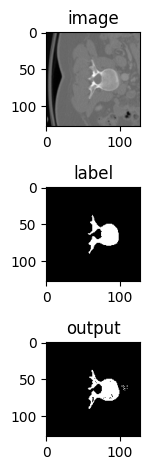

Best IoU: 0.5146, Best Dice: 0.6525, Best Acc: 0.9645


In [18]:
# -----------------------------
# Threshold method application
# -----------------------------

# empty the cache for model and training process
torch.cuda.empty_cache()

# Do the segmentation to exteract the spine part
# Threshold segmentation hyper parameters
minThreshold = 250
maxThreshold = 1500

# the variables for evaluation
total_correct_pixels = 0
total_pixels = 0
total_iou = 0.0
total_dice = 0.0

# set the hyper parameters and the paths 设置超参数和路径
data_path = "./dataset/Spineweb_dataset15/test/"    # the path of the dataset
file_list = os.listdir(data_path)  # list all files and folders in the folder(data path)
file_count = len(file_list)  # get the numer of files
print("Length of the dataset:",file_count)
resize_scale = (128,128)    # set the resize scale for images
print("----------------  Loading the dataset and evaluate  ----------------")
data_count = 0
poster_threshold = 200
for index in range(file_count):     # iterate the whole dataset
    metadata = np.load(data_path+str(index)+".npy")     # load the data
    image = np.array(Image.fromarray(metadata[0]).resize(resize_scale))     # Using the PIL to resize the transfer into npy again
    label = Image.fromarray((metadata[1] * 255).astype('uint8')).resize(resize_scale)     # Using the PIL to resize the transfer into npy again
    label = np.array(label)
    label[label < poster_threshold] = 0
    label[label >= poster_threshold] = 1
    
    # print(type(image),image.shape,image)
    # print(type(label),label.shape,label)
    output = CTimageLIB.thresholdSegmentation(image,minThreshold,maxThreshold)
    # evaluations
    current_correct_pixels,current_pixels = calculate_pixel_accuracy(output,label)
    current_iou = calculate_iou(output,label)
    current_dice = calculate_dice(output,label)
    # add the results to total one
    total_correct_pixels += current_correct_pixels
    total_pixels += current_pixels
    total_iou += current_iou
    total_dice += current_dice
    data_count += 1
    # visualize the results
    if index == 100:
        visualize_results(image,label,output)

final_acc = total_correct_pixels/total_pixels
final_iou = total_iou/data_count
final_dice = total_dice/data_count

print(f"Best IoU: {final_iou:.4f}, Best Dice: {final_dice:.4f}, Best Acc: {final_acc:.4f}")


Length of the dataset: 3005
----------------  Loading the dataset and evaluate  ----------------


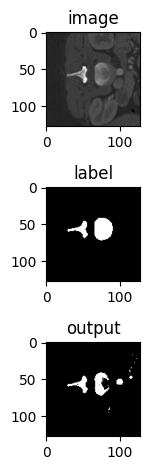

Best IoU: 0.4236, Best Dice: 0.5625, Best Acc: 0.9506


In [19]:
# -----------------------------
# Threshold method application
# -----------------------------

# empty the cache for model and training process
torch.cuda.empty_cache()

# Do the segmentation to exteract the spine part
# Threshold segmentation hyper parameters
minThreshold = 250
maxThreshold = 1500

# the variables for evaluation
total_correct_pixels = 0
total_pixels = 0
total_iou = 0.0
total_dice = 0.0

# set the hyper parameters and the paths 设置超参数和路径
data_path = "./dataset/Spineweb_dataset15/train/"    # the path of the dataset
file_list = os.listdir(data_path)  # list all files and folders in the folder(data path)
file_count = len(file_list)  # get the numer of files
print("Length of the dataset:",file_count)
resize_scale = (128,128)    # set the resize scale for images
print("----------------  Loading the dataset and evaluate  ----------------")
data_count = 0
poster_threshold = 200
for index in range(file_count):     # iterate the whole dataset
    metadata = np.load(data_path+str(index)+".npy")     # load the data
    image = np.array(Image.fromarray(metadata[0]).resize(resize_scale))     # Using the PIL to resize the transfer into npy again
    label = Image.fromarray((metadata[1] * 255).astype('uint8')).resize(resize_scale)     # Using the PIL to resize the transfer into npy again
    label = np.array(label)
    label[label < poster_threshold] = 0
    label[label >= poster_threshold] = 1
    
    # print(type(image),image.shape,image)
    # print(type(label),label.shape,label)
    output = CTimageLIB.thresholdSegmentation(image,minThreshold,maxThreshold)
    # evaluations
    current_correct_pixels,current_pixels = calculate_pixel_accuracy(output,label)
    current_iou = calculate_iou(output,label)
    current_dice = calculate_dice(output,label)
    # add the results to total one
    total_correct_pixels += current_correct_pixels
    total_pixels += current_pixels
    total_iou += current_iou
    total_dice += current_dice
    data_count += 1
    # visualize the results
    if index == 100:
        visualize_results(image,label,output)

final_acc = total_correct_pixels/total_pixels
final_iou = total_iou/data_count
final_dice = total_dice/data_count

print(f"Best IoU: {final_iou:.4f}, Best Dice: {final_dice:.4f}, Best Acc: {final_acc:.4f}")
